# Wordcloud with Shape - Spanish

In [1]:
import os
import numpy as np
import string
import matplotlib.pyplot as plt
import nltk
import textract
import stanza
import spacy_stanza
import cv2

from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download('omw-1.4')
stanza.download("es")

[nltk_data] Downloading package omw-1.4 to C:\Users\Juan
[nltk_data]     Fernando\anaconda3\lib\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


2023-02-10 11:30:51 INFO: Downloading default packages for language: es (Spanish) ...
2023-02-10 11:30:52 INFO: File exists: C:\Users\Juan Fernando\stanza_resources\es\default.zip
2023-02-10 11:30:55 INFO: Finished downloading models and saved to C:\Users\Juan Fernando\stanza_resources.


In [2]:
# define the path to the pdf file
text = textract.process('Proyecto_de_ley_Salud.pdf').decode("utf-8") 

In [3]:
def keyword(text):
    
    #define parameters for keywords
    min_word_length = 4
    ignore_words = ['artículo','parágrafo']
    
    # Create word tokens from the text string using Stanza to do lemmatization
    nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')
    doc = nlp(text)
    tokens = [word.lemma for sent in doc.sentences for word in sent.words]
    
    # List of punctuations to be ignored 
    punctuations = ['(',')',';',':','[',']',',','.','--','-','#','!','*','"','%']
    
    # Get the stopwords list
    stop_words = stopwords.words('spanish')

    # Convert ignore words  to lower case
    ignore_words_lower = [x.lower() for x in ignore_words]
    
    # Combine all the words to be ignored
    all_ignored_words = punctuations + stop_words + ignore_words_lower
    
    # Get the keywords list
    keywords = [word for word in tokens if  word.lower() not in all_ignored_words and len(word) >= min_word_length]    

    # Remove keywords that are digits
    keywords = [keyword for keyword in keywords if not keyword.isdigit()]

    # Return all keywords in lower case 
    keywords = [keyword.lower() for keyword in keywords]

    return keywords

In [4]:
def word_cloud_normal(keywords):
    
    # Convert keywords to dictionary with values and its occurences
    word_cloud_dict=Counter(keywords)

    # Define the parameters for the wordcloud
    wordcloud = WordCloud(background_color='white', max_words=100, 
                          colormap='Dark2', 
                          stopwords=STOPWORDS, 
                          max_font_size=256,
                          random_state=42, 
                          width=2000, 
                          height=1000).generate_from_frequencies(word_cloud_dict)
    
    # Plot the wordcloud
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('word_cloud_normal.png')
    plt.show()

In [5]:
# Extract the keywords
keywords = keyword(text)

2023-02-10 11:30:55 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-02-10 11:30:55 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2023-02-10 11:30:55 INFO: Use device: cpu
2023-02-10 11:30:55 INFO: Loading: tokenize
2023-02-10 11:30:55 INFO: Loading: mwt
2023-02-10 11:30:55 INFO: Loading: pos
2023-02-10 11:30:55 INFO: Loading: lemma
2023-02-10 11:30:55 INFO: Done loading processors!


### Plotting and adjusting the wordcloud to a shape

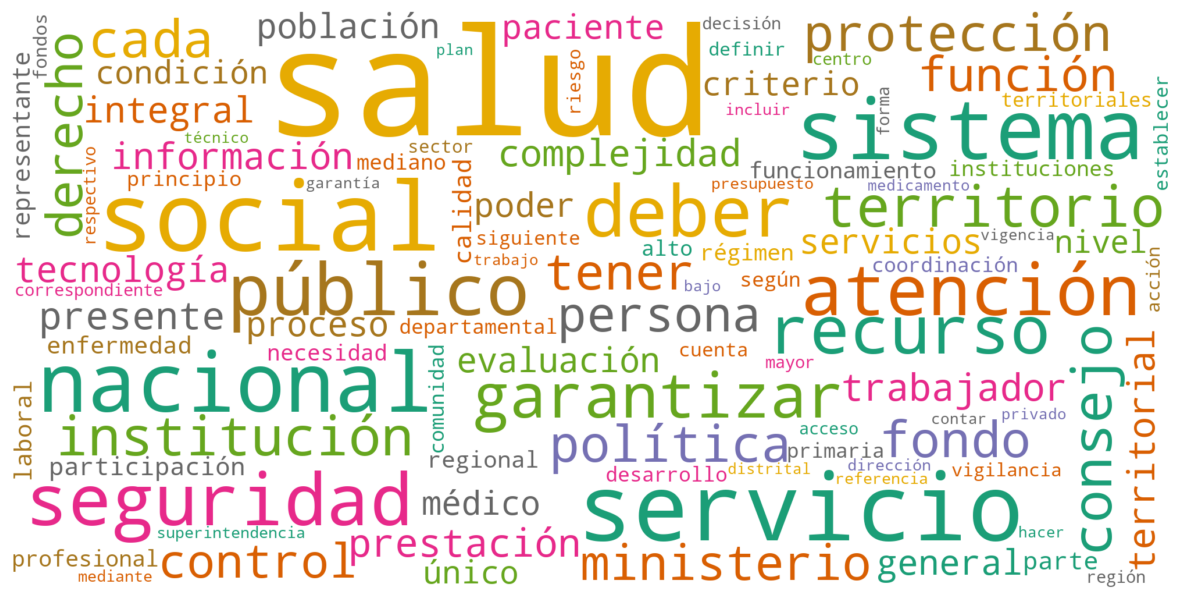

In [6]:
# Get our wordcloud
word_cloud_normal(keywords)

In [7]:
# Lets create a function to correct the background of a selectet image
def mask_corrector(image):
    image_mask = []
    for i in range(len(image)):
        image_mask_row=[]
        for j in range(image.shape[1]):
            r,g,b = image[i,j]
            average = float((r+g+b)/3)
            if r and g and b == average:
                pixel = (255,255,255)
            else:
                pixel = (r,g,b)
            image_mask_row.append(pixel)
        image_mask.append(image_mask_row)
    
    return np.array(image_mask)

In [8]:
def word_cloud_shape(keywords,image):
    
    # Convert keywords to dictionary with values and its occurences
    word_cloud_dict=Counter(keywords)
    
    # Call the image as a mask to define the shape of our wordcloud
    mask = np.array(Image.open(image).convert('RGB'),dtype='int64')
    mask = mask_corrector(mask)
    
    # Define the parameters for the wordcloud
    wordcloud = WordCloud(background_color='white', max_words=50, 
                          colormap='Dark2', 
                          stopwords=STOPWORDS, 
                          max_font_size=256,
                          random_state=42, 
                          width=1500, 
                          height=750, 
                          mask = mask).generate_from_frequencies(word_cloud_dict)
    
    # PLot the image, defining colors and shape of the wordcloud to be adjusted 
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.savefig('word_cloud_shape.png')
    plt.show()
 

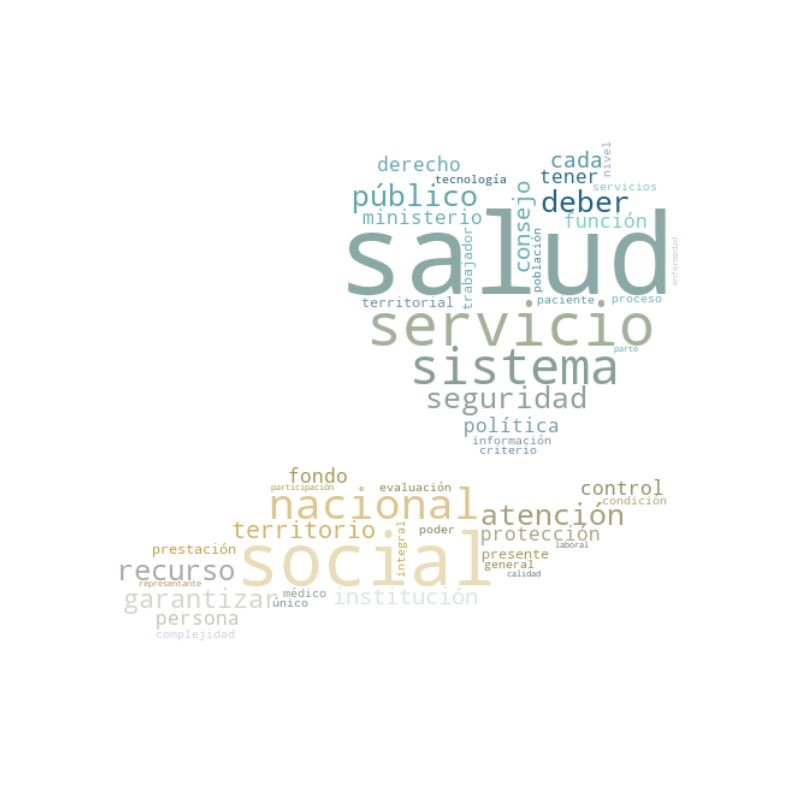

In [9]:
# Plot our wordcloud based on an image
word_cloud_shape(keywords,"health-icon.jpg")

### Optional: Get the shape of our image to add later to our wordcloud

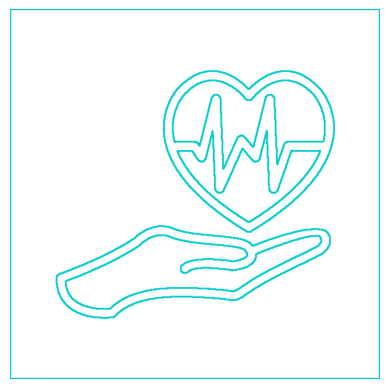

In [10]:
# Define a function to get the con
def contour(image):
    
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 100, 1, 0)
    
    # detect contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    copy_img = img.copy()
    cv2.drawContours(copy_img, contours, -1, (0,204,204), 2) # Define the colour o the contour
    
    # transform any other colour to white except pur defined contour
    image_mask = []
    for i in range(len(copy_img)):
        image_mask_row=[]
        for j in range(copy_img.shape[1]):
            r,g,b = copy_img[i,j]
            if r==0 and g==204 and b ==204:
                pixel = (0,204,204)
            else:
                pixel = (255,255,255)
            image_mask_row.append(pixel)
        image_mask.append(image_mask_row)
    plt.imshow(image_mask)
    plt.axis("off")
    plt.savefig('contour.png')
    
contour('health-icon.jpg')